In [14]:
import numpy as np
import pandas as pd
import os
import torch
import pymupdf

# Simple Retrieval Augmented Generation

The scope of this version is creating simple RAG: 
- The vector stores is just a list of embedded chunk vectors.
- Using *cosine-similarity* to check similarity between vectors.

**RAG pipeline**


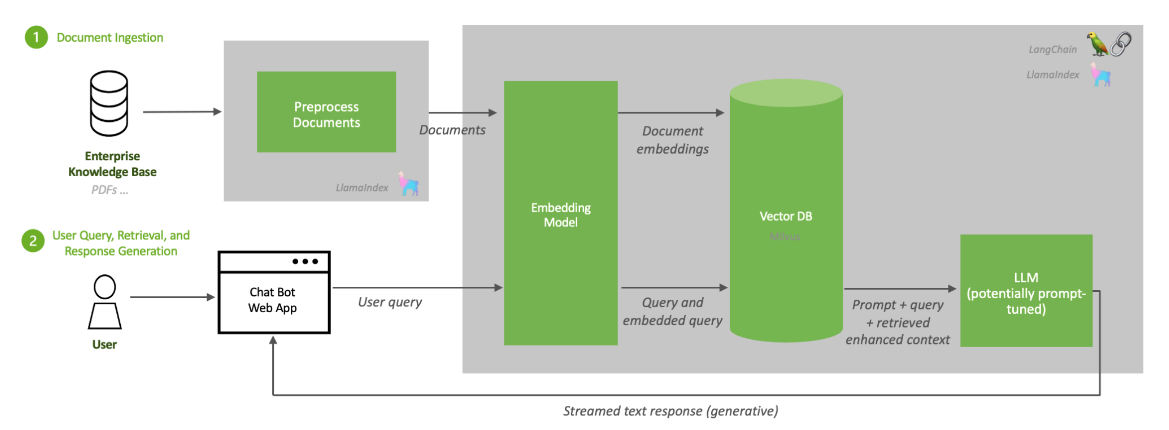

Base on the RAG pipeline, we will divided our works into section

## Preprocess document

In [ ]:
file_path = "../doc/Computer Networks.pdf"

doc = pymupdf.open(file_path)
sample_texts = [doc[i].get_text() for i in range(20, 30)]
sample_texts

In [ ]:
text = sample_texts[2]

# Clean any escape character: \n \t ..
filter = ''.join([chr(i) for i in range(1, 32)])
text = text.replace('\n', ' ')
text = text.translate(str.maketrans('', '', filter)).strip()
text = text.replace(u'\xa0', u' ')
print(text)
print(len(text))

**Chunk method**

For the chunk method, we will use **Fixed size chunking** method:
This is the most common and straightforward approach for chunking. 
Beside, overlapping will be used maintain the semantic context between each chunks

In [ ]:
def fixed_size_chunking(text: str, chunk_size=32):
    words = text.split(' ')
    output = []

    for i in range(len(words) - chunk_size + 1):
        chunk = ' '.join(words[i:i + chunk_size])
        output.append(chunk)

    return output


fixed_size_chunking(text)[:5]

In [ ]:
def clean_text(text: str):
    # filter = ''.join([chr(i) for i in range(1, 32)])
    # text = text.translate(str.maketrans('', '', filter)).strip()
    text = text.replace('-\n', '')
    text = text.replace('\n', ' ')
    text = text.replace(u'\xa0', u' ')

    while text.find('  ') != -1:
        text = text.replace('  ', ' ') 

    return text

def load_document(file_path: str, chunk_size=32):
    """
    Loads pdf from `file_path` and generate list of chunks from the file
    """
    doc = pymupdf.open(file_path)
    output = []

    chunk_id = 0
    for i, page in enumerate(doc):
        # Get text per page
        text = page.get_text()

        # Clean text
        text = clean_text(text)

        words = text.split(' ')
        for j in range(0, len(words) - chunk_size + 1, 2):
            chunk = ' '.join(words[j:j + chunk_size])

            output.append({
                'chunk_id': chunk_id,
                'page': i,
                'text': chunk,
            })

            chunk_id += 1
    
    return output

chunks = load_document(file_path)
chunks[:5]

In [ ]:
df = pd.DataFrame(chunks)
df['num_words'] = df.apply(lambda x : len(x['text'].split(' ')), axis=1)
df['num_char'] = df.apply(lambda x : len(x['text']), axis=1)
df

In [7]:
df.describe()

,chunk_id,page,num_words,num_char
count,192782.000000,192782.000000,192782.0,192782.000000
mean,96390.500000,483.769175,32.0,187.460048
std,55651.514135,266.907348,0.0,22.528302
min,0.000000,4.000000,32.0,63.000000
25%,48195.250000,254.000000,32.0,174.000000
50%,96390.500000,484.000000,32.0,186.000000
75%,144585.750000,717.000000,32.0,200.000000
max,192781.000000,961.000000,32.0,397.000000


## Embedding

In [21]:
from transformers import AutoTokenizer, AutoModel

model_name = "BAAI/bge-small-en-v1.5"

model_path = "../model/bge-small-en-v1.5/model"
tokenizer_path = "../model/bge-small-en-v1.5/tokenizer"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

RESET = False
tokenizer = None
model = None

if os.path.isdir(tokenizer_path) and os.path.isdir(model_path) and not RESET:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = AutoModel.from_pretrained(model_path)
    
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.to(device)

    tokenizer.save_pretrained(tokenizer_path)
    model.save_pretrained(model_path)


assert tokenizer is not None
assert model is not None

In [22]:
def get_embedding(text: list[str] | str):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

    with torch.no_grad():
        # reduce mean in sequence length axis
        output = model(**inputs).last_hidden_state.mean(dim=1)

    return output.tolist()

ce_output = get_embedding("When the second edition appeared in 1988, networks were used by universities and large businesses")
len(ce_output[0])

384

As we are using **BAAI/bge-small-en-v1.5** model, the final output will have shape (384, ), which mean a single chunk will be performed by 384 dimensional vector.

## Vector DB

In [15]:
sample_size = 100000
df = pd.read_csv('../csv/Computer Networks.csv', nrows=sample_size)

As the embedding column is in string format, we have to convert into numpy array

In [16]:
# Load sample vectors
sample = df[['chunk_id', 'embedding']].values

sample_vector_store = {}

for i in range(len(sample)):
    sample_vector_store[sample[i, 0]] = np.array(sample[i, 1].strip('[]').split(', '), dtype=np.float32)

## Retrieval

Cosine similarity formula:
$$cosine\_similarity = \frac{A.B}{||A||.||B||}$$

In [77]:
# Calculate cosine similarity
def cosine_similarity(a, b):
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    if norm_a == 0 or norm_b == 0:
        return 0
    else:
        return np.dot(a, b) / (norm_a * norm_b)
    
# Cosine similarity only consider the angle between 2 vector and ignore the magnitude
a = np.array([3, 4])
b = np.array([16, 17])
cosine_similarity(a, b)

0.17134117475124774

In [18]:
# TEST VERSION
def get_matches(vector_store, query, top_k=50):
    scores = {}

    for vector_key in vector_store:
        vector_item = vector_store[vector_key]
        scores[vector_key] = cosine_similarity(query, vector_item)

    def func(e):
        return e[1]
    
    # Sorted by cosine scores
    scores = sorted(scores.items(), key=func, reverse=True)[:top_k]

    return scores


# Test 
test_vs_0 = {}

for i in range(10):
    test_vs_0[i] = np.random.random((3, ))

print(f"Vector store: \n{test_vs_0}\n")

print(f"Cosine Similarity: \n{get_matches(test_vs_0, np.array([0.2, 0.7, 0.07]), 5)}")

Vector store: 
{0: array([0.8338602 , 0.63981512, 0.22945213]), 1: array([0.42540719, 0.87057095, 0.53867389]), 2: array([0.74558988, 0.17542384, 0.372393  ]), 3: array([0.90888781, 0.42535856, 0.23583108]), 4: array([0.82126247, 0.97994462, 0.91505896]), 5: array([0.62824154, 0.82937529, 0.34837184]), 6: array([0.59301151, 0.4497671 , 0.62385332]), 7: array([0.47751087, 0.64868194, 0.71745225]), 8: array([0.75492584, 0.45364247, 0.89036827]), 9: array([0.8185819 , 0.87847649, 0.01942071])}

Cosine Similarity: 
[(5, 0.9104244717896736), (1, 0.9030346474529437), (9, 0.8880851857511084), (0, 0.8016042726101591), (4, 0.7950683208332786)]


The `get_matches` function finds the top_k most similar chunks compared to query. Take query (str) as the input:
- We embed the query into (384, ) dimensional vector.
- Perform **cosine_similarity** formula to each chunk vector in vector_stores.
- Take most top_k highest scores from output. 

In [23]:
def get_matches(vector_store, query: str, top_k: int=100):
    # Embedding query
    ce_output = get_embedding(query)[0] # (1, 384)

    scores = {}

    for vector_key in vector_store:
        vector_item = vector_store[vector_key]
        scores[vector_key] = cosine_similarity(ce_output, vector_item)

    def func(e):
        return e[1]
    
    # Sorted by cosine scores
    scores = sorted(scores.items(), key=func, reverse=True)[:top_k]
    ids = [score[0] for score in scores]

    return scores, ids

# Test 
test_vs_0 = {}

for i in range(10):
    test_vs_0[i] = np.random.random((384, ))

output, id = get_matches(test_vs_0, 'heloo', 5)
print(f"Cosine Similarity: \n{output}")

Cosine Similarity: 
[(2, 0.08063958676405446), (9, 0.03814639791802448), (6, 0.026497118965112688), (5, 0.021391380677912585), (7, 0.011214473809244195)]


## Augmenting & Generative
In this section, we will augment extracted similar chunk to our prompt. For this project, we will use **Gemini API**

In [26]:
from dotenv import load_dotenv
import google.generativeai as genai

load_dotenv()

API_KEY = os.getenv('API_KEY')
genai.configure(api_key=API_KEY)

In [27]:
gen_model = genai.GenerativeModel('gemini-1.0-pro-latest')
# Test
gen_model.generate_content("What is the main part of the integrated services architecture").text

'Service Delivery Subsystem'

In [35]:
def create_prompt(query: str, info: list[str]):
    ret = '\n- '
    prompt = f"I have the following information: \n- {ret.join(info)} \
    \nNow, i want you taking those information and answer the following question \
    \n\n{query} \n \
    \nMake sure the answers are detail and as exploratory as possible. Only take info from information list."
    return prompt

print(create_prompt('question', ['info1', 'info2']))

I have the following information: 
- info1
- info2     
Now, i want you taking those information and answer the following question     

question 
     
Make sure the answers are detail and as exploratory as possible. Only take info from information list.


In [36]:
query = "What is the main part of the integrated services architecture"

scores, match_ids = get_matches(sample_vector_store, query)

# get list text from matches id
info = df[df['chunk_id'].isin(match_ids)]['text'].tolist()

prompt = create_prompt(query, info)
print(prompt)

gen_model = genai.GenerativeModel('gemini-1.0-pro-latest')
gen_model.generate_content(prompt).text

I have the following information: 
- purpose of each layer is to offer certain services to the higher layers while shielding those layers from the details of how the offered services are actually implemented. In a sense, each
- the offered services are actually implemented. In a sense, each layer is a kind of virtual machine, offering certain services to the layer above it. This concept is actually a familiar one
- services are actually implemented. In a sense, each layer is a kind of virtual machine, offering certain services to the layer above it. This concept is actually a familiar one and is
- the specification of the interfaces is part of the architecture because these are hidden away inside the machines and not visible from the outside. It is not even necessary that the interfaces
- of the interfaces is part of the architecture because these are hidden away inside the machines and not visible from the outside. It is not even necessary that the interfaces on all
- interfaces is pa

'The main part of the integrated services architecture that is visible to the users of the network is RSVP (Resource reSerVation Protocol). RSVP is described in RFCs 2205–2210 and is used for making reservations. Other protocols are used to actually set up the flows, but RSVP is the protocol that is used to make the reservations.'

## Results

Given the following question: *"What is the main part of the integrated services architecture?* <br>


**Answer before giving prompt**: *Service Delivery Subsystem* 

<br>

**Answer after giving prompt**: *The main part of the integrated services architecture that is visible to the users of the network is RSVP (Resource reSerVation Protocol). RSVP is described in RFCs 2205–2210 and is used for making reservations. Other protocols are used to actually set up the flows, but RSVP is the protocol that is used to make the reservations.* 

<br>

**Original information from PDF**: *The main part of the integrated services architecture that is visible to the users of the network is RSVP. It is described in RFCs 2205–2210. This protocol is used for making the reservations; other protocols are used for sending the data. RSVP allows multiple senders to transmit to multiple groups of receivers, permits individual receivers to switch channels freely, and optimizes bandwidth use while at the same time eliminating congestion*

<br>

From the answer of LLM model, we can actually extract the desired information from vector stores. 

However, we want to make sure that the desired information belong to the top score in the search as we take 100 highest scores. 

In [61]:
keywords = ['services', 'integrated services', 'part', 'rsvp']

# Scan each row
view = []
for text in info:
    row = []
    for keyword in keywords:
        row.append(1 if text.lower().find(keyword) != -1 else 0)
    view.append(row)

view = pd.DataFrame(view, columns=keywords)

# Which sentence contains service keyword ?
view[view['services'] == 1].head()

,services,integrated services,part,rsvp
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
9,1,0,0,0
10,1,0,0,0


In [62]:
# Which sentence talks about integrated service ?
view[view['integrated services'] == 1].head()

,services,integrated services,part,rsvp
41,1,1,0,0
42,1,1,0,0
43,1,1,0,0
44,1,1,0,0
45,1,1,0,0


In [78]:
# # Which sentence talks about RSVP ?
# display(view[view['rsvp'] == 1].head())

# Extracted chunk about RSVP
[info[i] for i in view[view['rsvp'] == 1].index.to_list()]

['would not work at all. RSVP—The Resource reSerVation Protocol The main part of the integrated services architecture that is visible to the users of the network is RSVP. It is described in',
 'work at all. RSVP—The Resource reSerVation Protocol The main part of the integrated services architecture that is visible to the users of the network is RSVP. It is described in RFCs 2205–2210.',
 'all. RSVP—The Resource reSerVation Protocol The main part of the integrated services architecture that is visible to the users of the network is RSVP. It is described in RFCs 2205–2210. This protocol',
 'Resource reSerVation Protocol The main part of the integrated services architecture that is visible to the users of the network is RSVP. It is described in RFCs 2205–2210. This protocol is used',
 'Protocol The main part of the integrated services architecture that is visible to the users of the network is RSVP. It is described in RFCs 2205–2210. This protocol is used for making',
 'main part of the i

> **Insight**: 

- Based on the dataframe, the chunks only containing the keyword 'services' have the highest scores. Meanwhile, the phrase 'integrated services' ranks only 41st in top highest scores. <br>
This is the disadvantage of cosine-similarity function as cosine similarity only consider the angle between 2 vectors and ignore the magnitude of them. That mean as well as those 2 vectors have the same direction, it has the similarity of 1, no matter their magnitudes are significantly different.

- The desired paragraph about RSVP is only taken until '... other protocols are used' and no further chunks covering the next part. This causes LLM model confused, leading to misunderstanding about the other protocols. <br>
As the searching method is simple, we can not capture the further chunks which providing more details about RSVP. Those chunks have no similarity as they don't contain any word in question.

- We are currently testing on small size vector store, which the search can go through every vector inside the database to check for similarity. However for further application and larger vector database, they approach will be slow and expensive computing.